In [1]:
import pandas as pd
import numpy as np

from nltk.corpus import stopwords

import re

import string

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, classification_report, roc_auc_score ,confusion_matrix

from nltk.stem import WordNetLemmatizer, PorterStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from sklearn.naive_bayes import MultinomialNB, GaussianNB


import seaborn as sns

import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 10)

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
df = pd.read_csv("/Users/uditnath/Documents/Artificial Intelligence/Toxic comment classifier/train.csv")
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
def clean_text(text):
    if isinstance(text, str):
        text = text.lower()
        text = re.sub(r"i'm", "i am", text)
        text = re.sub(r"he's", "he is", text)
        text = re.sub(r"she's", "she is", text)
        text = re.sub(r"it's", "it is", text)
        text = re.sub(r"that's", "that is", text)
        text = re.sub(r"what's", "that is", text)
        text = re.sub(r"where's", "where is", text)
        text = re.sub(r"how's", "how is", text)
        text = re.sub(r"'ll", " will", text)
        text = re.sub(r"'ve", " have", text)
        text = re.sub(r"'re", " are", text)
        text = re.sub(r"won't", "will not", text)
        text = re.sub(r"can't", "cannot", text)
        text = re.sub(r"n't", " not", text)
        text = re.sub(r"'bout", "about", text)
        text = re.sub(r"'til", "until", text)
        text = re.sub(r"[-()/@;:{}`+=~|.!?,]", "", text)
        text = text.translate(str.maketrans('', '', string.punctuation))
        text = re.sub("(\W)", " ", text)
        text = re.sub(r"\b(\w+)\b", r"\1", text)

    return text
df["clean_text"] = df['comment_text'].apply(lambda text: clean_text(text))
df[['comment_text', 'clean_text']].head(2)



,comment_text,clean_text
0,Explanation\nWhy the edits made under my usern...,explanation why the edits made under my userna...
1,D'aww! He matches this background colour I'm s...,daww he matches this background colour i am se...


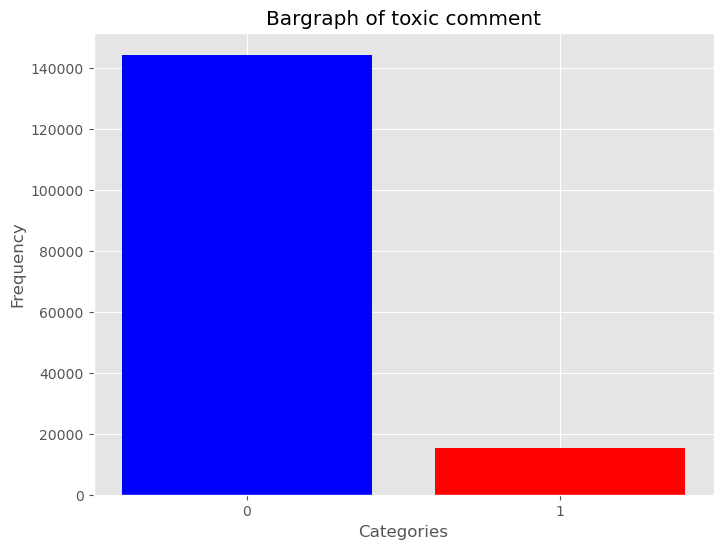

In [5]:
category_counts = df['toxic'].value_counts()
colors = ['blue', 'red']

plt.figure(figsize=(8, 6))
plt.bar(category_counts.index, category_counts.values, color=colors)


plt.xlabel('Categories')
plt.ylabel('Frequency')
plt.title('Bargraph of toxic comment')
plt.xticks(category_counts.index, ['0', '1'])
plt.grid(True)

# Show the plot
plt.show()

In [6]:
cols_target = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']
X_train, X_test, y_train, y_test = train_test_split(df['clean_text'], df[cols_target], test_size=0.2, random_state=42)


In [7]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(127656,)
(127656, 6)
(31915,)
(31915, 6)


In [8]:
# Apply TF-IDF vectorization to the training and test data
vect = TfidfVectorizer(
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\b\w{1,}\b',
    ngram_range=(1, 3),
    stop_words='english',
    sublinear_tf=True
)

# Convert X_train and X_test to string type if they are not already
X_train = X_train.astype(str)
X_test = X_test.astype(str)

X_train = vect.fit_transform(X_train)
X_test = vect.transform(X_test)


In [9]:
from sklearn.multiclass import OneVsRestClassifier

# Train the multilabel classifier using the One-vs-Rest strategy with Multinomial Naive Bayes
model = OneVsRestClassifier(MultinomialNB())
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

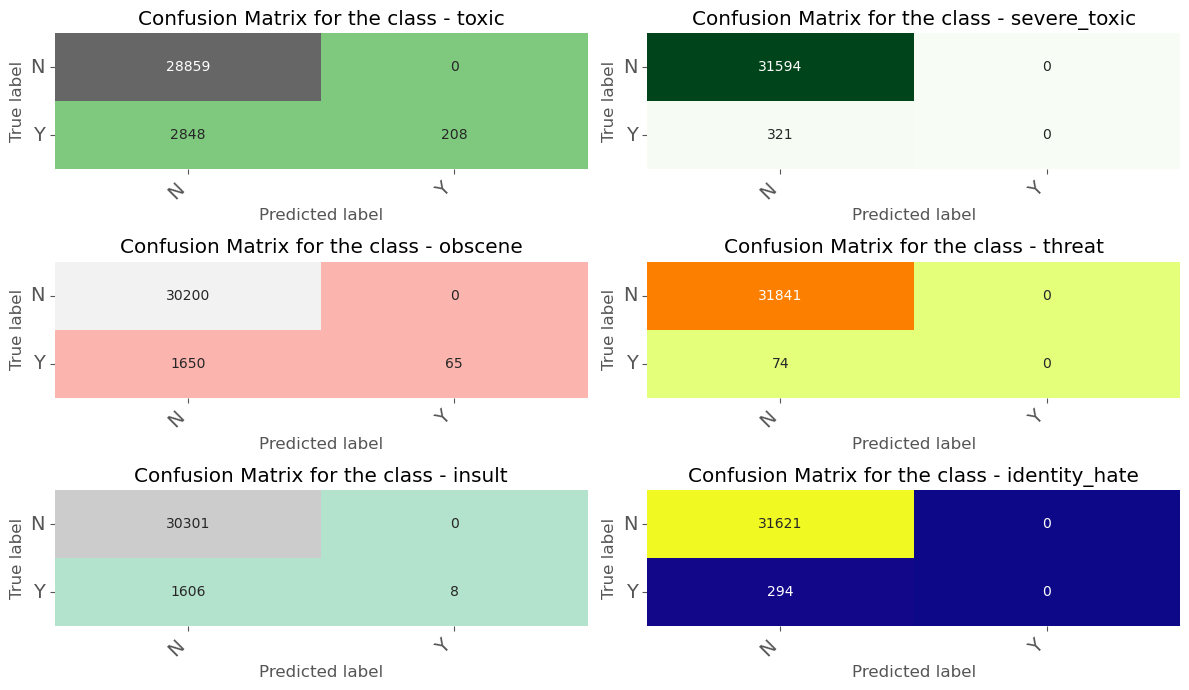

In [10]:
# Calculate and print the confusion matrix for each class
cfs = []
for i in range(6):
    cf = confusion_matrix(y_test[cols_target[i]], y_pred[:, i])
    cfs.append(cf)

def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, cmap, fontsize=14):
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)
    heatmap = sns.heatmap(df_cm, annot=True, cmap=cmap, fmt="d", cbar=False, ax=axes)
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title("Confusion Matrix for the class - " + class_label)

fig, ax = plt.subplots(3, 2, figsize=(12, 7))
cmaps = ['Accent', 'Greens', 'Pastel1', 'Wistia', 'Pastel2', 'plasma']

for axes, cfs_matrix, label, i in zip(ax.flatten(), cfs, cols_target, range(6)):
    c = cmaps[i]
    print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"], c, 14)

fig.tight_layout()
plt.show()

In [11]:
from sklearn.metrics import accuracy_score

# Assuming you have the predicted labels stored in 'y_pred' and the true labels in 'y_test'

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)

# Print the accuracy
print(f"Accuracy: {accuracy}")


Accuracy: 0.8986683377722074


In [12]:
cr = pd.DataFrame(classification_report(y_test,y_pred, target_names=cols_target,output_dict=True)).T
cr['support'] = cr.support.apply(int)
cr.style.background_gradient(cmap='Pastel1')

/Users/uditnath/miniforge3/envs/ml/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/uditnath/miniforge3/envs/ml/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/uditnath/miniforge3/envs/ml/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
toxic,1.000000,0.068063,0.127451,3056
severe_toxic,0.000000,0.000000,0.000000,321
obscene,1.000000,0.037901,0.073034,1715
threat,0.000000,0.000000,0.000000,74
insult,1.000000,0.004957,0.009864,1614
identity_hate,0.000000,0.000000,0.000000,294
micro avg,1.000000,0.039723,0.076411,7074
macro avg,0.500000,0.018487,0.035058,7074
weighted avg,0.902601,0.039723,0.075016,7074
samples avg,0.006517,0.002636,0.003604,7074


#Making prediction using test statement

In [13]:
custom_statement = "You are a bitch"

# Preprocess the custom statement
preprocessed_statement = clean_text(custom_statement)

# Vectorize the preprocessed statement
vectorized_statement = vect.transform([preprocessed_statement])

# Make predictions on the vectorized statement
predicted_labels = model.predict(vectorized_statement)

# Print the predicted labels
for i, label in enumerate(cols_target):
    print(f"{label}: {predicted_labels[0, i]}")


toxic: 1
severe_toxic: 0
obscene: 1
threat: 0
insult: 0
identity_hate: 0


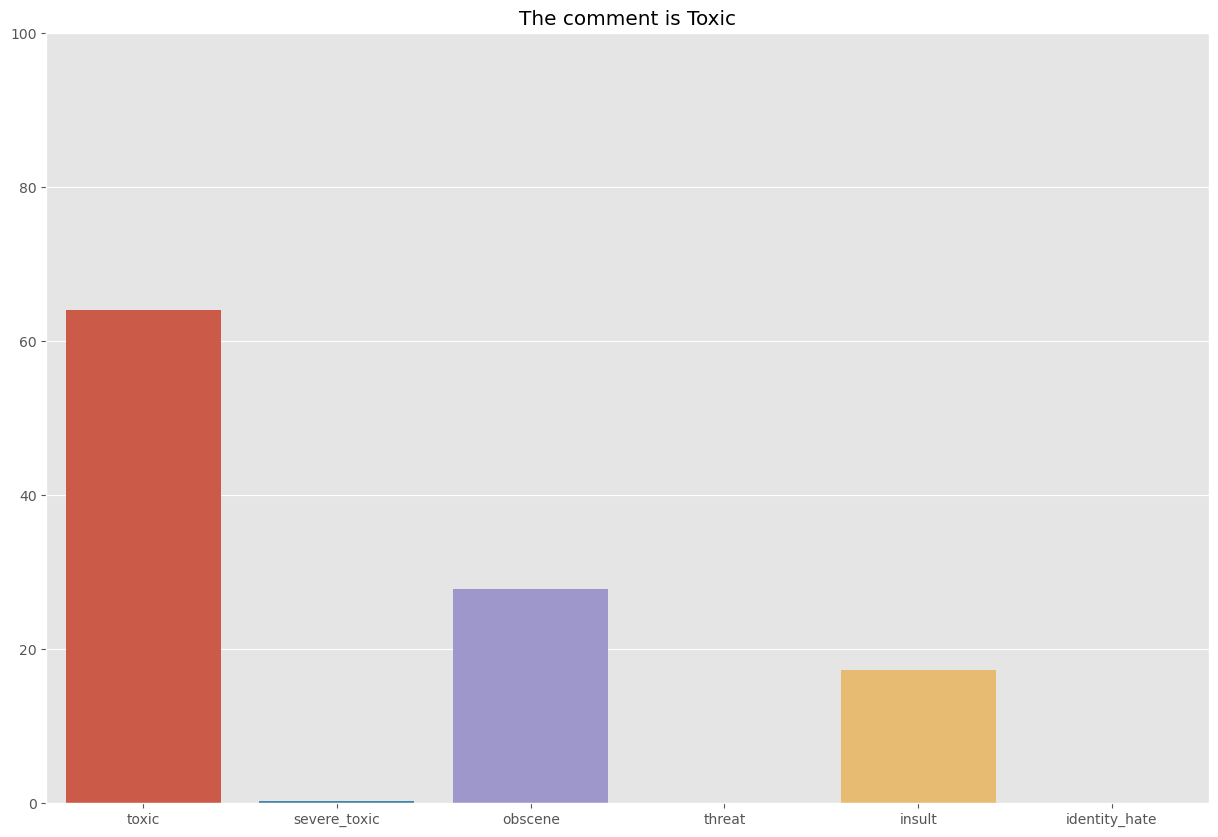

In [14]:
def make_test_predictions(df,classifier):

    df.comment_text = df.comment_text.apply(clean_text)

    X_test = df.comment_text

    X_test_transformed = vect.transform(X_test)

    y_test_pred = classifier.predict_proba(X_test_transformed)

    a = np.array(y_test_pred[0])


    sns.barplot(x = cols_target,y =a*100)

    plt.ylim((0,100))

    result =  sum(y_test_pred[0])

    if result >= 1:

       plt.title('The comment is Toxic')


    else :

      plt.title('The comment is Non Toxic')
#Enter the comment
comment_text = "Bitch you die"

comment ={'id':[1],'comment_text':[comment_text]}

comment = pd.DataFrame(comment)

make_test_predictions(comment,model)

In [15]:
import joblib

# Export the trained model
joblib.dump(model, 'tcc_model.pkl')


['tcc_model.pkl']